In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import functools
import json
import os
import ssl
import time

import fsspec
import irods_fsspec
from fsspec.registry import get_filesystem_class
from irods.session import iRODSSession
irods_fsspec.register()

In [3]:
_ENV = None
ssl_context = ssl.create_default_context(purpose=ssl.Purpose.SERVER_AUTH, cafile=None, capath=None, cadata=None)
try:
    env_file = os.environ['IRODS_ENVIRONMENT_FILE']
except KeyError:
    env_file = os.path.expanduser('~/.irods/irods_environment.json')
session = iRODSSession(irods_env_file=env_file, ssl_context=ssl_context)
with open(env_file, 'r') as f:
    _ENV = json.load(f)

In [4]:
test_subcollection = f'/iplant/home/{_ENV["irods_user_name"]}/delete_me_benchmark_test'
if not session.collections.exists(test_subcollection):
    session.collections.create(test_subcollection)

In [9]:
@functools.lru_cache(None)
def measure_data_object_create_delete(n_iter):
    # pre-emptive cleanup of incomplete benchmarks
    for i in range(n_iter):
        test_file_path = test_subcollection + f'/test_{i}.txt'
        if session.data_objects.exists(test_file_path):
            session.data_objects.unlink(test_file_path)
    
    start = time.perf_counter()
    for i in range(n_iter):
        test_file = session.data_objects.create(test_subcollection + f'/test_{i}.txt')
        with test_file.open(mode='w') as f:
            f.write(b'foo!\n')

    create_elapsed = time.perf_counter() - start
    create_t_per_iter = create_elapsed / n_iter
    print(f'created {n_iter} in {create_elapsed} s -- {create_t_per_iter} s / iter')
    
    start = time.perf_counter()
    for i in range(n_iter):
        test_file_path = test_subcollection + f'/test_{i}.txt'
        session.data_objects.unlink(test_file_path)
    unlink_elapsed = time.perf_counter() - start
    unlink_t_per_iter = unlink_elapsed / n_iter
    print(f'deleted {n_iter} in {unlink_elapsed} s -- {unlink_t_per_iter} s / iter')
    return create_t_per_iter, unlink_t_per_iter

In [10]:
n_iter_vals = [1, 5, 10, 50, 100, 150]
create_t_per_iter_vals = []
unlink_t_per_iter_vals = []
for n_iter in n_iter_vals:
    print(n_iter)
    create_t_per_iter, unlink_t_per_iter = measure_data_object_create_delete(n_iter)
    create_t_per_iter_vals.append(create_t_per_iter)
    unlink_t_per_iter_vals.append(unlink_t_per_iter)

1
created 1 in 4.706547019 s -- 4.706547019 s / iter
deleted 1 in 0.8193793290000002 s -- 0.8193793290000002 s / iter
5
created 5 in 23.368390608999995 s -- 4.673678121799999 s / iter
deleted 5 in 3.779640570000005 s -- 0.755928114000001 s / iter
10
created 10 in 47.532015306000005 s -- 4.7532015306 s / iter
deleted 10 in 7.72218312599999 s -- 0.7722183125999991 s / iter
50
created 50 in 152.094113806 s -- 3.04188227612 s / iter
deleted 50 in 38.417881661000024 s -- 0.7683576332200005 s / iter
100
created 100 in 231.21455847199996 s -- 2.3121455847199996 s / iter
deleted 100 in 77.00560658699999 s -- 0.7700560658699999 s / iter
150
created 150 in 324.527248743 s -- 2.1635149916199996 s / iter
deleted 150 in 116.41297298899997 s -- 0.7760864865933331 s / iter


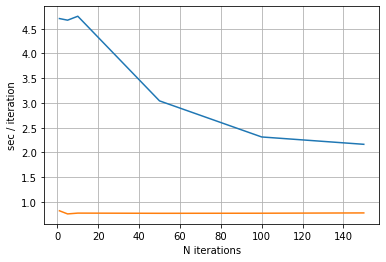

In [14]:
plt.plot(n_iter_vals, create_t_per_iter_vals, label='Create iRODS data object')
plt.plot(n_iter_vals, unlink_t_per_iter_vals, label='Unlink iRODS data object')
plt.xlabel('N iterations')
plt.ylabel('sec / iteration')
plt.grid()

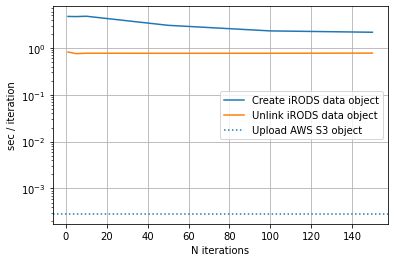

In [16]:
plt.plot(n_iter_vals, create_t_per_iter_vals, label='Create iRODS data object')
plt.plot(n_iter_vals, unlink_t_per_iter_vals, label='Unlink iRODS data object')
plt.axhline(1/3500, ls=':', label='Upload AWS S3 object')
plt.xlabel('N iterations')
plt.ylabel('sec / iteration')
plt.yscale('log')
plt.legend()
plt.grid()

In [20]:
@functools.lru_cache(None)
def measure_data_object_get(n_iter):
    for i in range(n_iter):
        test_file_path = test_subcollection + f'/test_{i}.txt'
        if not session.data_objects.exists(test_file_path):
            test_file = session.data_objects.create(test_file_path)
            with test_file.open(mode='w') as f:
                f.write(b'foo!\n')
    
    start = time.perf_counter()
    for i in range(n_iter):
        test_file = session.data_objects.get(test_subcollection + f'/test_{i}.txt')
        with test_file.open(mode='r') as f:
            _ = f.read()

    get_elapsed = time.perf_counter() - start
    get_t_per_iter = get_elapsed / n_iter
    print(f'got {n_iter} in {get_elapsed} s -- {get_t_per_iter} s / iter')
    return get_t_per_iter

In [21]:
get_t_per_iter_vals = []
for n_iter in n_iter_vals:
    print(n_iter)
    get_t_per_iter = measure_data_object_get(n_iter)
    get_t_per_iter_vals.append(get_t_per_iter)

1
got 1 in 0.5202615129999231 s -- 0.5202615129999231 s / iter
5
got 5 in 4.429384623000033 s -- 0.8858769246000066 s / iter
10
got 10 in 7.311939362999965 s -- 0.7311939362999965 s / iter
50
got 50 in 33.620805147000056 s -- 0.6724161029400011 s / iter
100
got 100 in 88.58616520600003 s -- 0.8858616520600003 s / iter
150
got 150 in 97.90827468799989 s -- 0.6527218312533326 s / iter


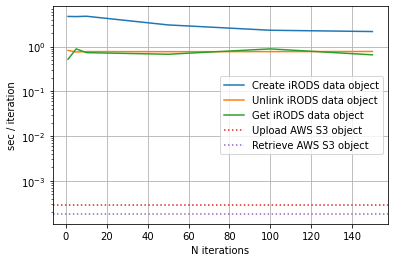

In [23]:
plt.plot(n_iter_vals, create_t_per_iter_vals, label='Create iRODS data object')
plt.plot(n_iter_vals, unlink_t_per_iter_vals, label='Unlink iRODS data object')
plt.plot(n_iter_vals, get_t_per_iter_vals, label='Get iRODS data object')
plt.axhline(1/3500, c='C3', ls=':', label='Upload AWS S3 object')
plt.axhline(1/5500, c='C4', ls=':', label='Retrieve AWS S3 object')
plt.xlabel('N iterations')
plt.ylabel('sec / iteration')
plt.yscale('log')
plt.legend()
plt.grid()